# Imports

In [168]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from scipy.interpolate import splrep, BSpline # for Spline graphs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"
import math
import warnings
warnings.filterwarnings("ignore")

In [169]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'zscore_score',
   'zscore_round_duration',
   'zscore_efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   'ort_img',
   'rep_man',
   'soc_pers',
   'team_size',
   'difficulty',
   'score',
   'duration',
   'efficiency',
   'timestamp']},
 'dat': {'filename': 'DAT_output_conversation_level.csv',
  'cols_to_ignore':

# Per-Task Splines
This notebook contains univariate spline models to show how different independent variables relate to the dependent variable(s) of interest, for each task.


# Jury

### Full Data (100)%

In [170]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'rf')

In [171]:
# this is the conversation data for the juries
juries_model.conv

,gini_coefficient_num_words,gini_coefficient_num_chars,gini_coefficient_num_messages,gini_coefficient_function_word_accommodation,average_positive_bert,stdev_positive_bert,min_positive_bert,max_positive_bert,average_negative_bert,stdev_negative_bert,...,Q20type_3_type_4,Q22confl_tradeoffs,Q23ss_out_uncert,Q24eureka_question,Q2intel_manip_1,Q21intellective_judg_1,Q5creativity_input_1,Q25_type6_mixed_motive,target_raw,target_std
0,-0.968071,-0.903531,-0.403874,-0.060432,0.646356,0.717879,0.469979,0.245807,-0.043844,0.302531,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118
1,-1.433233,-1.470332,0.829248,-1.689152,-0.293294,-0.180408,-0.412163,0.290992,0.353607,0.904269,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,0.600000,-1.368196
2,-0.066840,-0.153075,1.250815,0.836746,-0.796815,-1.015673,0.719373,-1.376046,1.218315,0.479345,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,0.666667,-0.977643
3,0.436618,0.224799,1.199282,0.894008,-0.422633,-0.549036,-0.517383,-0.068313,-0.569256,-0.285146,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,0.750000,-0.489453
4,-1.597555,-1.721074,-2.573892,-1.808114,0.125517,0.797358,-0.149221,0.958074,-0.802791,-0.142220,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.709929,0.634267,0.632421,1.246257,0.783603,0.119937,1.492585,0.092300,-0.788423,0.703380,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118
344,-0.010102,-0.090349,3.183299,1.401415,3.664821,1.721237,1.069400,0.919969,-2.642732,-2.417341,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,0.800000,-0.196539
345,1.208444,1.263388,2.099592,0.212735,3.446339,1.929767,0.145186,0.931435,-2.417840,-1.282506,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118
346,-1.153047,-0.915726,-0.254613,-0.771451,0.594014,0.695029,0.292817,0.881477,-0.092745,2.060340,...,0.181818,0.863636,0.590909,0.0,0.03913,0.365217,0.208696,1,1.000000,0.975118


In [172]:
# drop columns that have 1 unique values between all rows
def drop_invariant_columns(df):
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    return(df.drop(cols_to_drop, axis=1))

In [173]:
def get_columns_with_signal(df):

    # drop invariant columns are part of this
    df = drop_invariant_columns(df)

    # List of columns to exclude from correlation calculation
    columns_to_exclude = ["target_std", "target_raw"]

    # Calculate correlations
    correlation_list = []
    for column in df.columns:
        if column not in columns_to_exclude:
            correlation = np.corrcoef(df[column], df["target_std"])[0][1]
            correlation_list.append((column, correlation))

    # Sort the list based on correlation values
    correlation_list.sort(key=lambda x: abs(x[1]), reverse=True)

    # Filter out columns with absolute correlation < 0.1
    filtered_correlation_list = [(column, correlation) for column, correlation in correlation_list if abs(correlation) >= 0.1]

    # Sort the filtered list based on correlation values
    filtered_correlation_list.sort(key=lambda x: abs(x[1]), reverse=True)

    return([col for col, correlation in filtered_correlation_list])

In [174]:
juries_model.conv[get_columns_with_signal(juries_model.conv)]

,average_positivity_zscore_chats,average_positive_bert,max_positivity_zscore_conversation,stdev_positivity_zscore_chats,stdev_positive_bert,average_user_num_chars,average_user_num_words,max_user_num_chars,average_1st_person_pl.,average_hashedge,...,average_feel,average_hedge_words,average_direct_question,average_textblob_subjectivity,average_past_tense,average_hedge_naive,max_negation,average_preposition,max_preposition,max_direct_question
0,0.646356,0.646356,-0.900509,0.717879,0.717879,0.924751,1.056470,-0.116403,0.675922,0.890184,...,0.193519,0.040081,1.608550,-0.608887,-0.305913,0.102857,-0.273382,0.731699,1.575112,0.971666
1,-0.293294,-0.293294,0.642693,-0.180408,-0.180408,1.304328,1.194997,0.746405,0.300534,0.153915,...,-0.441107,0.704422,-0.798138,0.372714,-0.684886,0.803747,-0.273382,-0.032772,0.846204,-1.029161
2,-0.796815,-0.796815,-0.350896,-1.015673,-1.015673,-0.880933,-0.927144,-0.630211,-0.314837,-1.670686,...,-1.013484,-0.220526,2.994219,-0.526557,-0.240772,-0.172087,-0.273382,-1.017187,-0.611613,0.971666
3,-0.422633,-0.422633,0.829638,-0.549036,-0.549036,0.071355,0.059075,0.193820,-0.284170,-0.340019,...,-0.379075,-0.174432,0.195098,-0.477282,-0.619828,-0.123457,-0.273382,-1.108902,-1.340521,0.971666
4,0.125517,0.125517,-0.025591,0.797358,0.797358,2.255442,2.288545,0.896670,1.992805,1.060466,...,1.132931,0.586114,1.809107,0.608872,-1.052315,0.678931,-1.714848,-0.588017,1.575112,0.971666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.783603,0.783603,-0.514037,0.119937,0.119937,-1.437788,-1.407681,-1.289435,0.053159,-1.695328,...,-0.844308,-1.188494,-0.798138,0.354156,-0.131895,-1.193309,-0.273382,-0.538670,-0.611613,-1.029161
344,3.664821,3.664821,-1.896948,1.721237,1.721237,-0.702176,-0.480133,-0.935587,-0.073339,-2.022861,...,-0.766769,-1.188494,0.505485,-2.063840,-1.246380,-1.193309,-1.714848,-2.238401,-0.611613,0.971666
345,3.446339,3.446339,-1.935201,1.929767,1.929767,-0.542378,-0.529024,-0.286057,0.430175,-2.678591,...,-1.309541,-1.188494,-0.389158,-0.810827,-1.157338,-1.193309,-0.273382,-2.233885,-2.069429,0.971666
346,0.594014,0.594014,-0.160100,0.695029,0.695029,0.045128,0.037889,-0.198806,-0.434095,-0.801828,...,-0.344614,-1.188494,0.746896,-1.222589,-0.974689,-1.193309,-0.273382,-1.138145,-0.611613,0.971666


In [175]:
sns.set_context("paper", rc={"axes.labelsize":20})
sns.set_context("talk", font_scale=1.4)

def plot_single_linear_model(conversation_data, x_vars, y_vars, num_top_plots=None):
    num_plots = len(x_vars) * len(y_vars)
    num_rows = len(y_vars)
    num_cols = len(x_vars)
    num_plots_per_row = min(5, num_cols)

    num_rows_needed = math.ceil(num_plots / num_plots_per_row)
    fig_height = num_rows_needed * 5
    fig_width = num_plots_per_row * 5

    plt.figure(figsize=(fig_width, fig_height))
    
    plot_num = 1
    r_squared_values = []
    
    if num_top_plots is not None:
        all_r_squared = []

    for y_var in y_vars:
        for x_var in x_vars:
            if num_top_plots is not None:
                x_data = conversation_data[x_var].values.reshape(-1, 1)
                y_data = conversation_data[y_var].values

                # Fit linear regression model
                model = LinearRegression()
                model.fit(x_data, y_data)

                # Predict using the model
                y_pred = model.predict(x_data)

                # Calculate R-squared
                r_squared = r2_score(y_data, y_pred)
                all_r_squared.append((x_var, y_var, r_squared))
            
            if num_top_plots is None or plot_num <= num_top_plots:
                plt.subplot(num_rows_needed, num_plots_per_row, plot_num)
                sns.scatterplot(x=x_var, y=y_var, data=conversation_data)
                
                if num_top_plots is not None:
                    plt.plot(x_data, y_pred, color='red')
                    
                plot_num += 1
                
                if plot_num > num_plots:
                    break
    
    plt.tight_layout()
    plt.show()
    
    if num_top_plots is not None:
        r_squared_df = pd.DataFrame(all_r_squared, columns=['x_var', 'y_var', 'r_squared'])
        r_squared_df = r_squared_df.sort_values(by='r_squared', ascending=False).head(num_top_plots)

    return(r_squared_df)

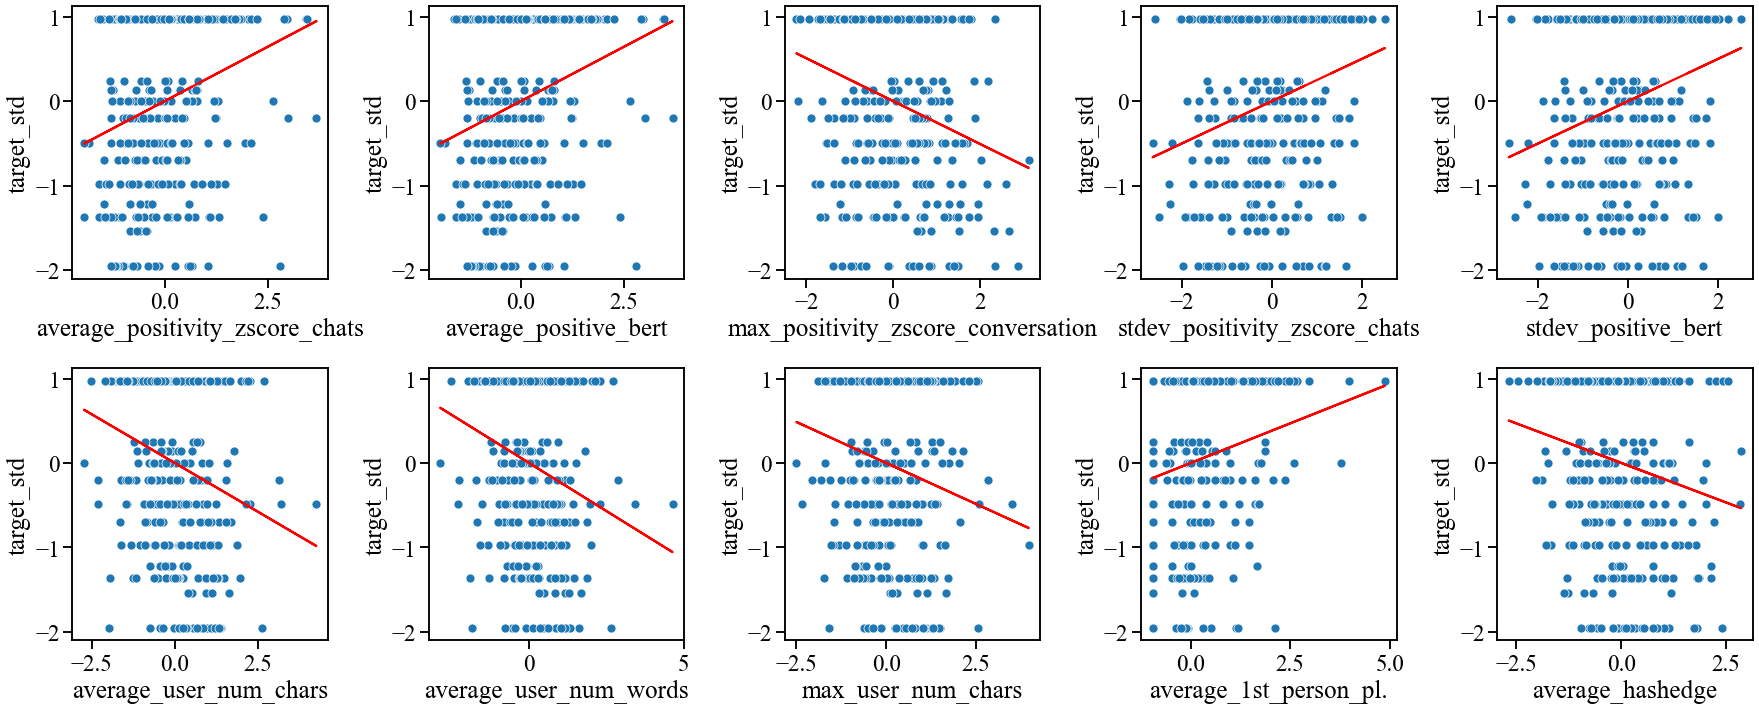

In [176]:
r2_jury_simple_models = plot_single_linear_model(juries_model.conv, get_columns_with_signal(juries_model.conv), ["target_std"], num_top_plots=10)

In [177]:
r2_jury_simple_models

,x_var,y_var,r_squared
0,average_positivity_zscore_chats,target_std,0.067130
1,average_positive_bert,target_std,0.067130
2,max_positivity_zscore_conversation,target_std,0.064660
3,stdev_positivity_zscore_chats,target_std,0.063032
4,stdev_positive_bert,target_std,0.063032
5,average_user_num_chars,target_std,0.053624
6,average_user_num_words,target_std,0.052279
7,max_user_num_chars,target_std,0.037811
8,average_1st_person_pl.,target_std,0.035360
9,average_hashedge,target_std,0.035327


### 75% of Data

In [178]:
# juries_model75 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_75/')
# juries_model75.select_target(target=["majority_pct"])
# juries_model75.define_model(model_type = 'rf')

### 50% Data

In [179]:
# juries_model50 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_50/')
# juries_model50.select_target(target=["majority_pct"])
# juries_model50.define_model(model_type = 'rf')

### 25% of Data

In [180]:
# juries_model25 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_25/')
# juries_model25.select_target(target=["majority_pct"])
# juries_model25.define_model(model_type = 'rf')

# CSOP (blended)

### Full Data (100%)

In [181]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'rf')

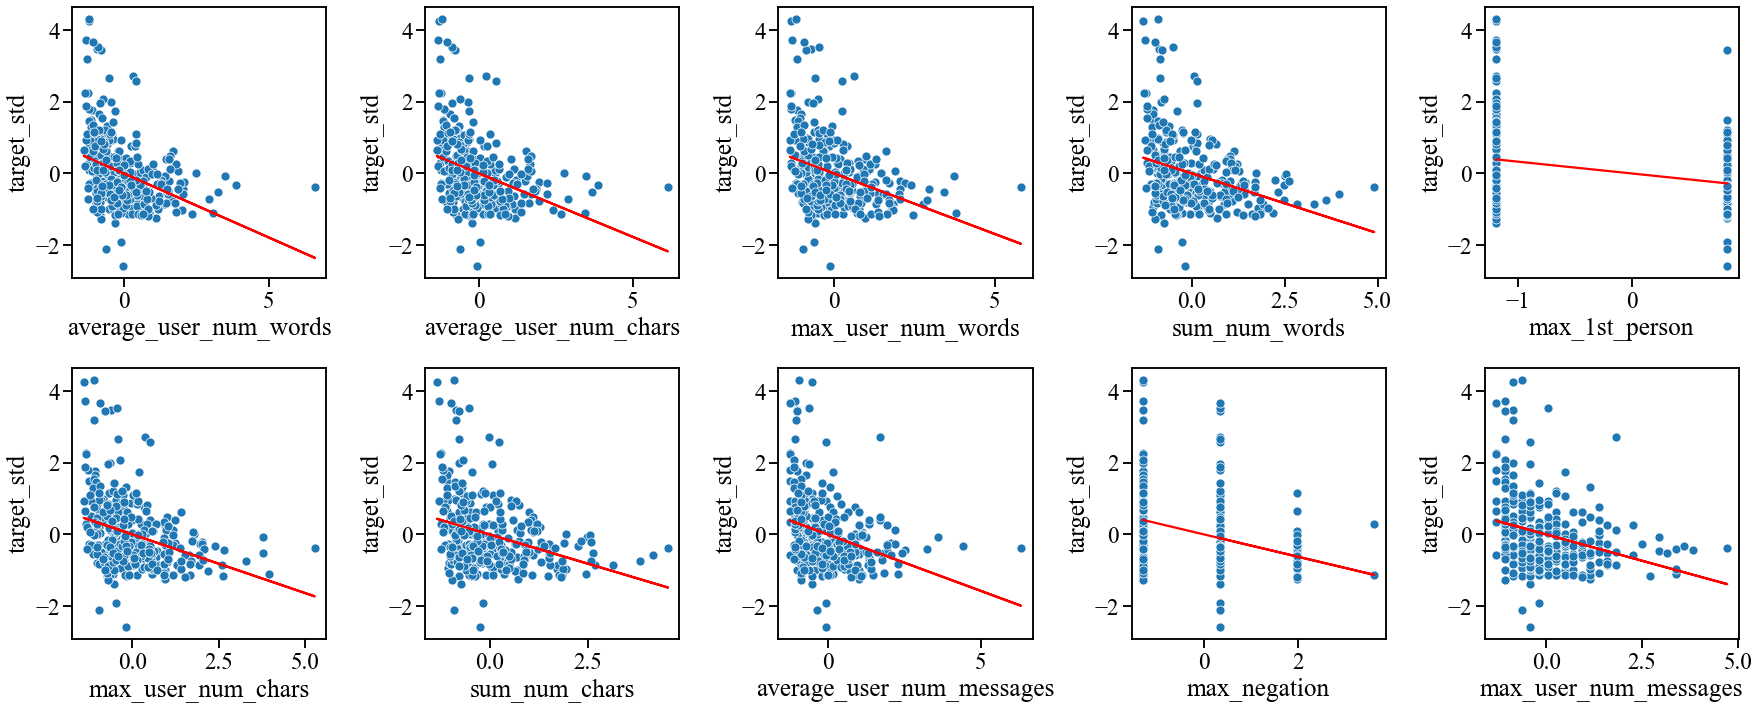

In [182]:
r2_csop_simple_models = plot_single_linear_model(csop_blended_model.conv, get_columns_with_signal(csop_blended_model.conv), ["target_std"], num_top_plots=10)

In [183]:
r2_csop_simple_models

,x_var,y_var,r_squared
0,average_user_num_words,target_std,0.127710
1,average_user_num_chars,target_std,0.125189
2,max_user_num_words,target_std,0.114137
3,sum_num_words,target_std,0.111172
4,max_1st_person,target_std,0.108685
5,max_user_num_chars,target_std,0.107548
6,sum_num_chars,target_std,0.107117
7,average_user_num_messages,target_std,0.099053
8,max_negation,target_std,0.096671
9,max_user_num_messages,target_std,0.086741


### 75% Data

In [184]:
# csop_blended_model75 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_75/')
# csop_blended_model75.select_target(target=["zscore_efficiency", "efficiency"])
# csop_blended_model75.define_model(model_type = 'rf')

### 50% Data

In [185]:
# csop_blended_model50 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_50/')
# csop_blended_model50.select_target(target=["zscore_efficiency", "efficiency"])
# csop_blended_model50.define_model(model_type = 'rf')

### 25% Data

In [186]:
# csop_blended_model25 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_25/')
# csop_blended_model25.select_target(target=["zscore_efficiency", "efficiency"])
# csop_blended_model25.define_model(model_type = 'rf')

# DAT

### Full data (100%)

In [187]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'rf')

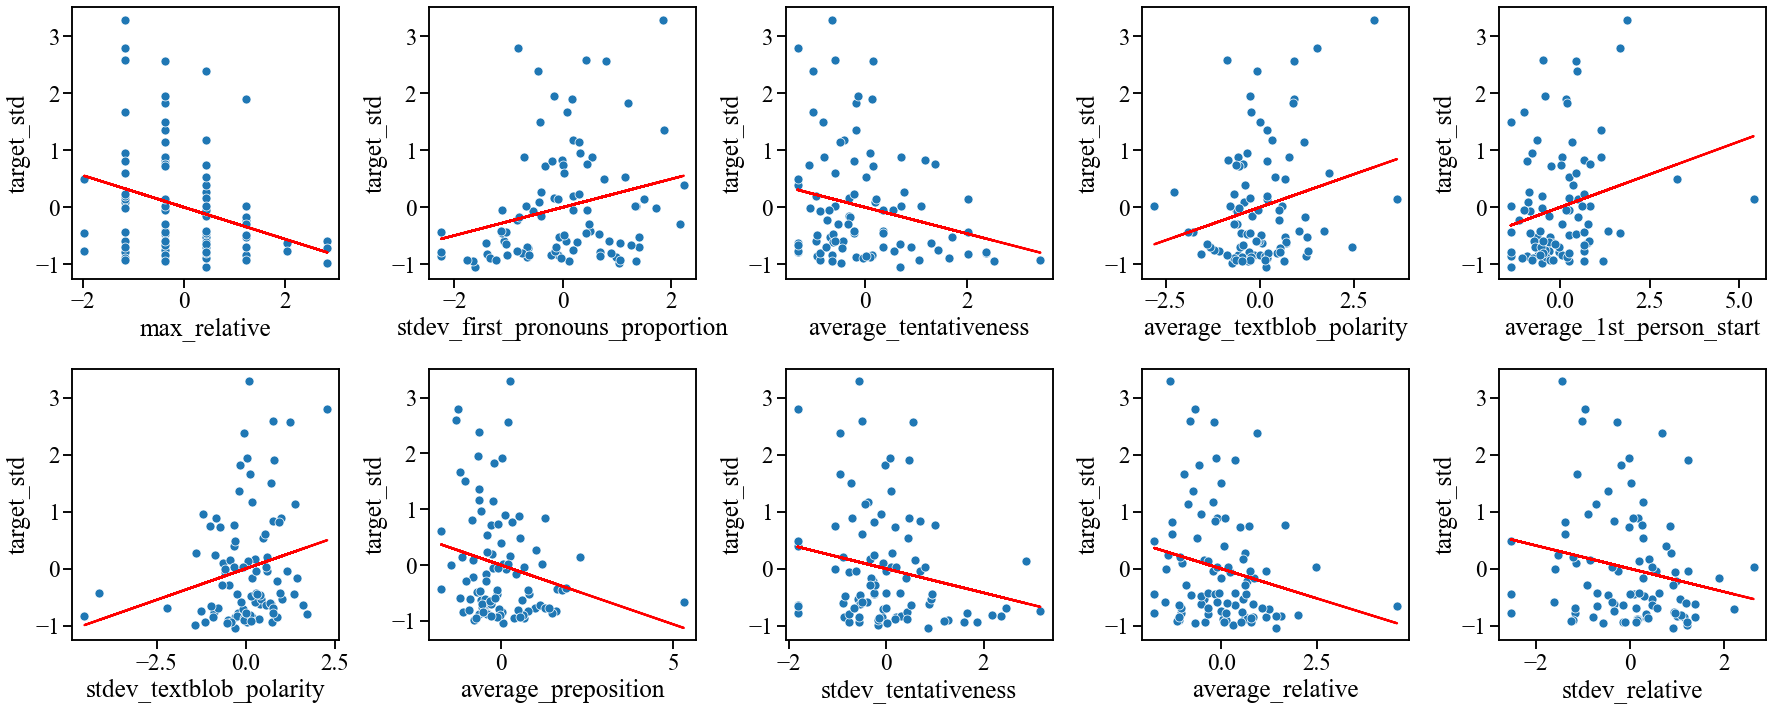

In [188]:
r2_dat_simple_models = plot_single_linear_model(dat_model.conv, get_columns_with_signal(dat_model.conv), ["target_std"], num_top_plots = 10)

In [189]:
r2_dat_simple_models

,x_var,y_var,r_squared
0,max_relative,target_std,0.079049
1,stdev_first_pronouns_proportion,target_std,0.061903
2,average_tentativeness,target_std,0.054459
3,average_textblob_polarity,target_std,0.054095
4,average_1st_person_start,target_std,0.054073
5,stdev_textblob_polarity,target_std,0.048431
6,average_preposition,target_std,0.045547
7,stdev_tentativeness,target_std,0.045423
8,average_relative,target_std,0.044379
9,stdev_relative,target_std,0.041888


### 75% Data

In [190]:
dat_model75 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_75/')
dat_model75.select_target(target=["efficiency"])
dat_model75.define_model(model_type = 'rf')

### 50% Data

In [191]:
dat_model50 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_50/')
dat_model50.select_target(target=["efficiency"])
dat_model50.define_model(model_type = 'rf')

### 25% Data

In [192]:
dat_model25 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_25/')
dat_model25.select_target(target=["efficiency"])
dat_model25.define_model(model_type = 'rf')

# Estimation

### Full Data (100%)

In [193]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'rf')

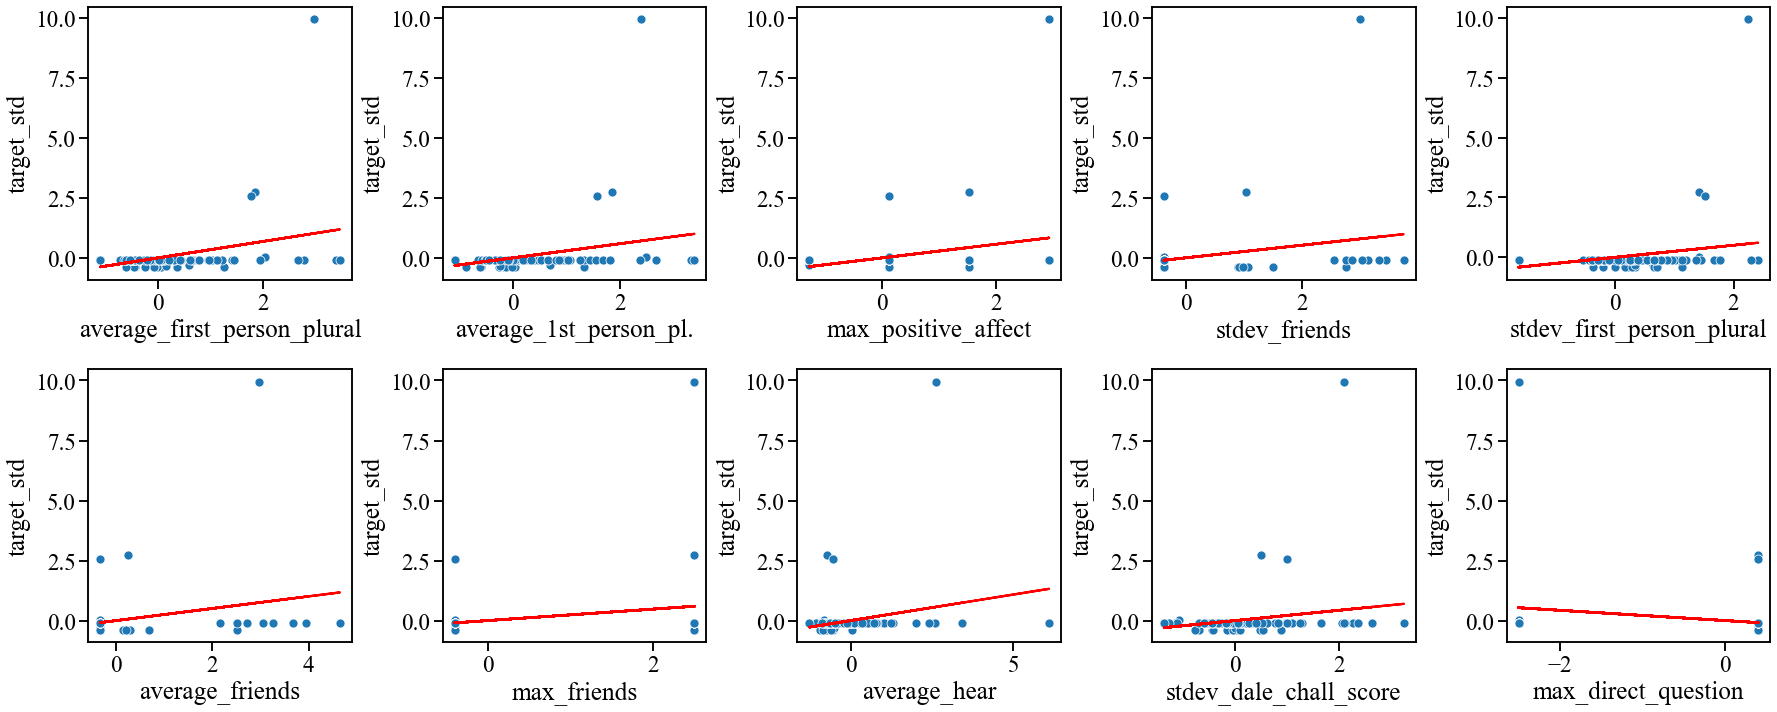

In [194]:
r2_estimation_simple_models = plot_single_linear_model(estimation_blended_model.conv, get_columns_with_signal(estimation_blended_model.conv), ["target_std"], num_top_plots = 10)

In [195]:
r2_estimation_simple_models

,x_var,y_var,r_squared
0,average_first_person_plural,target_std,0.117913
1,average_1st_person_pl.,target_std,0.087222
2,max_positive_affect,target_std,0.081069
3,stdev_friends,target_std,0.069140
4,stdev_first_person_plural,target_std,0.064362
5,average_friends,target_std,0.063446
6,max_friends,target_std,0.056876
7,average_hear,target_std,0.046969
8,stdev_dale_chall_score,target_std,0.046147
9,max_direct_question,target_std,0.045714


### 75% Data

In [196]:
# estimation_blended_model75 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_75/')
# estimation_blended_model75.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
# estimation_blended_model75.define_model(model_type = 'rf')

### 50% Data

In [197]:
# estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/')
# estimation_blended_model50.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
# estimation_blended_model50.define_model(model_type = 'rf')

### 25% Data

In [198]:
# estimation_blended_model25 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_25/')
# estimation_blended_model25.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
# estimation_blended_model25.define_model(model_type = 'rf')